In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm 

import time

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 07: Redução de dimensionalidade

**1.** Considere o conjunto de dados disponível em penguins.csv, organizado em 5
colunas, sendo 4 colunas de atributos e a última a classe do padrão. Os dados
referem-se a medições anatômicas de pinguins da Antártida, classificados nas
espécies Adelie, Chinstrap e Gentoo. Maiores detalhes sobre os dados podem
ser conferidos em https://allisonhorst.github.io/palmerpenguins/.

Apresente a projeção em 2 dimensões dos padrões acima obtida pelo método PCA (análise dos componentes principais).

Ainda considerando o item anterior, calcule e mostre a variância explicada
obtida quando a dimensão projetada é modificada (1,2,3 ou 4).

Normalize os dados antes de executar PCA. Implemente sua própria versão de PCA, mas verifique a corretude comparando contra alguma implementação popular (e.g., da biblioteca scikitlearn).

In [2]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

In [3]:
penguins_csv = pd.read_csv('penguins.csv')
penguins = pd.read_excel('penguins_xlsx.xlsx')

In [4]:
print(penguins.isna().sum())

penguins.fillna(penguins.mean(), inplace=True)

features = penguins.iloc[:, 0:4]

bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
padrao               0
dtype: int64


In [5]:
print(penguins['padrao'].value_counts())

0.000000e+00    146
2.000000e+18    119
1.000000e+18     68
Name: padrao, dtype: int64


In [6]:
# Normalizando os dados
scaler = StandardScaler()
normalized_data = scaler.fit_transform(features) 

# Realizando o PCA do sklearn
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(normalized_data)

# Criando um DataFrame com as componentes principais
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, penguins[['padrao']]], axis=1)

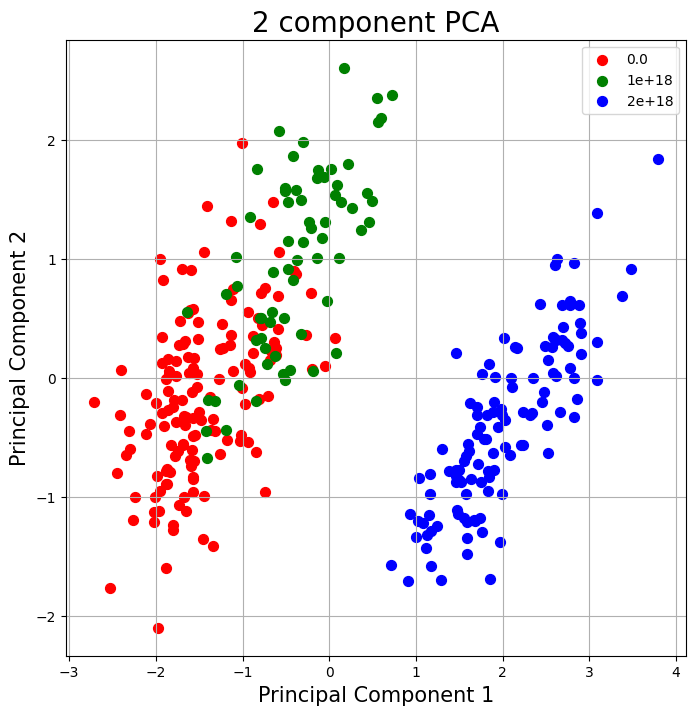

In [7]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)
ax.set_title('2 component PCA', fontsize=20)

targets = [0.0, 1.0e+18, 2.0e+18]  # Ajustamos os targets para os valores únicos na coluna 'padrao'
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['padrao'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'], finalDf.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
ax.legend(targets)
ax.grid()

plt.show()

In [8]:
for n in range(1, 5):
    pca = PCA(n_components=n)
    principalComponents = pca.fit_transform(normalized_data)

    # Calcula e exibir a variância explicada
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"Variância explicada com {n} componentes: {explained_variance}")

Variância explicada com 1 componentes: 0.68633893135999
Variância explicada com 2 componentes: 0.8808682242049917
Variância explicada com 3 componentes: 0.9730288540858752
Variância explicada com 4 componentes: 1.0


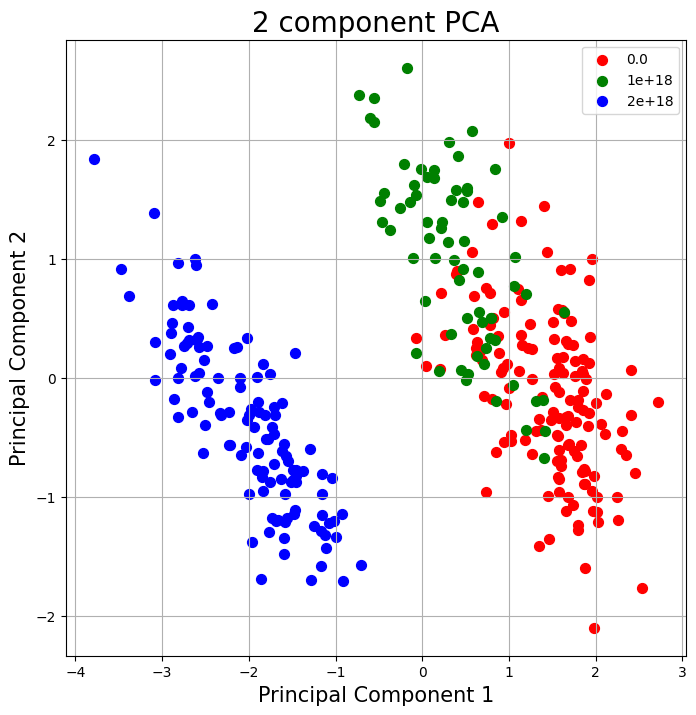

Variância explicada com 1 componentes: 0.6863389313599904
Variância explicada com 2 componentes: 0.8808682242049916
Variância explicada com 3 componentes: 0.973028854085875
Variância explicada com 4 componentes: 1.0


In [9]:
def my_pca(X, n_components, y):
    
    # 1. Centraliza os dados
    X_centered = X - np.mean(X, axis=0)
    
    # 2. Calcula a matriz de covariância
    cov_matrix = np.cov(X_centered.T)
    
    # 3. Calcula os autovalores e autovetores da matriz de covariância
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # 4. Ordena os autovalores e autovetores por autovalores em ordem decrescente
    eig_pairs = [(np.abs(eigenvalues[i]), eigenvectors[:,i]) for i in range(len(eigenvalues))]
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    
    # 5. Seleciona as primeiras n_components autovetores (componentes principais)
    matrix_w = np.hstack([eig_pairs[i][1].reshape(X.shape[1],1) for i in range(n_components)])
    
    # 6. Retorna a projeção dos dados nos componentes principais
    projected_data = X_centered.dot(matrix_w)
        
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Principal Component 1', fontsize=15)
    ax.set_ylabel('Principal Component 2', fontsize=15)
    ax.set_title(f'{n_components} component PCA', fontsize=20)

    targets = [0.0, 1.0e+18, 2.0e+18]  
    colors = ['r', 'g', 'b']
    for target, color in zip(targets, colors):
        indicesToKeep = y == target
        ax.scatter(projected_data[indicesToKeep, 0], projected_data[indicesToKeep, 1], c=color, s=50)
    ax.legend(targets)
    ax.grid()

    plt.show()
    
    # Calcula e exibe a variância explicada
    for n in range(1, 5):
        explained_variance = sum(eig_pairs[i][0] for i in range(n)) / sum(eig_pairs[i][0] for i in range(len(eig_pairs)))
        print(f"Variância explicada com {n} componentes: {explained_variance}")
        

my_pca(normalized_data, 2, penguins['padrao'].values)

É possível ver que os resultados da implementação do Sklearn e a versão própria estão equivalentes, como é possível ver através da variância explicada, que tem valores iguais em ambas implementações. A única diferença notável está na direção dos gráficos, que apontam em direções opostas, mas isso pode ser explicado pelos autovetores retornados pela implementação, que devem estar sendo multiplicados por -1 em uma e não na outra.

**2.** Implemente um autoencoder determinísitco para o banco de dados MNIST, que já usamos em exercícios anteriores. Você pode escolher utilizar tanto CNN como MLP no encoder/decoder. No entanto, o encoder deve mapear as imagens no $\mathbb{R}^2$, para podermos visualizar as representações latentes no plano. Use o conjunto de validação para fazer early stopping. Você também pode monitorar o erro na validação para anelar a taxa de aprendizado (usando um scheduler). Finalmente, mostre a projeção das imagens de teste no espaço latente e comente qualitativamente os embeddings obtidos.

In [12]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import optim

# Definindo a arquitetura do autoencoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(32 * 7 * 7, 2)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(2, 32 * 7 * 7)
        self.conv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 32, 7, 7)
        x = torch.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Inicialização do Autoencoder
autoencoder = Autoencoder()

# Hiperparâmetros
num_epochs = 15
learning_rate = 0.001

# Loss e Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Dataloaders para treino e teste
batch_size = 128
train_loader = DataLoader(
    datasets.MNIST(
        root='.',
        train=True,
        download=True,
        transform=transforms.ToTensor(),
    ),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = DataLoader(
    datasets.MNIST(
        root='.',
        train=False,
        transform=transforms.ToTensor(),
    ),
    batch_size=batch_size,
    shuffle=False,
)

# Treinamento
for epoch in range(num_epochs):
    for batch_features, _ in train_loader:
        # Forward pass
        outputs = autoencoder(batch_features)
        loss = criterion(outputs, batch_features)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Época : {epoch+1}/{num_epochs}, Perda = {loss.item()}")


100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:02<00:00, 3482434.36it/s]


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



100%|███████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 1761743.10it/s]


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:01<00:00, 1376233.53it/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 2333479.76it/s]


Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw

Época : 1/15, Perda = 0.05962779372930527
Época : 2/15, Perda = 0.05355651676654816
Época : 3/15, Perda = 0.053545478731393814
Época : 4/15, Perda = 0.051574163138866425
Época : 5/15, Perda = 0.053315989673137665
Época : 6/15, Perda = 0.05086669698357582
Época : 7/15, Perda = 0.05047200620174408
Época : 8/15, Perda = 0.049686118960380554
Época : 9/15, Perda = 0.046524155884981155
Época : 10/15, Perda = 0.04768930748105049
Época : 11/15, Perda = 0.05077965930104256
Época : 12/15, Perda = 0.04879872500896454
Época : 13/15, Perda = 0.04637473449110985
Época : 14/15, Perda = 0.044604212045669556
Época : 15/15, Perda = 0.047341588884592056


In [17]:
def train_autoencoder(autoencoder, train_loader, valid_loader, num_epochs, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1)
    
    train_losses = []
    valid_losses = []
    
    best_valid_loss = float('inf')
    early_stopping_counter = 0
    
    for epoch in range(num_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        
        autoencoder.train()
        for images, _ in train_loader:
            images = images.to(device)
            
            optimizer.zero_grad()
            outputs = autoencoder(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        autoencoder.eval()
        with torch.no_grad():
            for images, _ in valid_loader:
                images = images.to(device)
                outputs = autoencoder(images)
                loss = criterion(outputs, images)
                valid_loss += loss.item() * images.size(0)
        
        train_loss /= len(train_loader.dataset)
        valid_loss /= len(valid_loader.dataset)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        print(f"Época [{epoch+1}/{num_epochs}], Perda de Treino: {train_loss:.4f}, Perda de Validação: {valid_loss:.4f}")
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= 3:
                break
        
        scheduler.step(valid_loss)
    
    return train_losses, valid_losses

Época [1/15], Perda de Treino: 0.0467, Perda de Validação: 0.0465
Época [2/15], Perda de Treino: 0.0464, Perda de Validação: 0.0462
Época [3/15], Perda de Treino: 0.0462, Perda de Validação: 0.0461
Época [4/15], Perda de Treino: 0.0460, Perda de Validação: 0.0459
Época [5/15], Perda de Treino: 0.0459, Perda de Validação: 0.0458
Época [6/15], Perda de Treino: 0.0457, Perda de Validação: 0.0457
Época [7/15], Perda de Treino: 0.0456, Perda de Validação: 0.0455
Época [8/15], Perda de Treino: 0.0454, Perda de Validação: 0.0454
Época [9/15], Perda de Treino: 0.0453, Perda de Validação: 0.0452
Época [10/15], Perda de Treino: 0.0452, Perda de Validação: 0.0453
Época [11/15], Perda de Treino: 0.0451, Perda de Validação: 0.0451
Época [12/15], Perda de Treino: 0.0450, Perda de Validação: 0.0450
Época [13/15], Perda de Treino: 0.0450, Perda de Validação: 0.0449
Época [14/15], Perda de Treino: 0.0449, Perda de Validação: 0.0450
Época [15/15], Perda de Treino: 0.0448, Perda de Validação: 0.0448


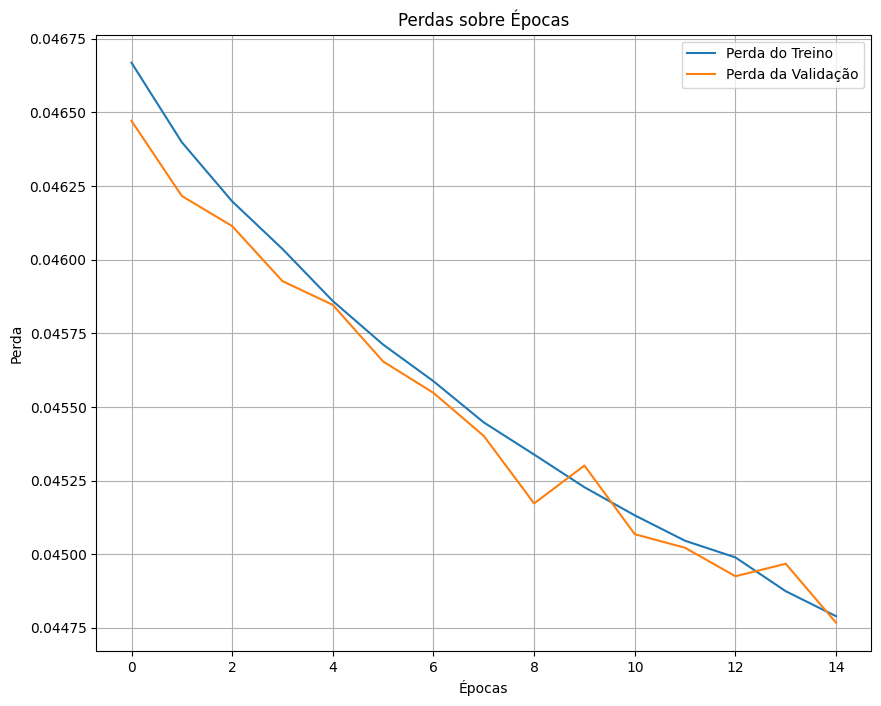

In [18]:
# Treinando o autoencoder e obtendo as perdas de treinamento e validação
train_losses, valid_losses = train_autoencoder(autoencoder, train_loader, test_loader, num_epochs, learning_rate)

# Plotando as perdas de treinamento e validação
plt.figure(figsize=(10, 8))
plt.plot(train_losses, label='Perda do Treino')
plt.plot(valid_losses, label='Perda da Validação')
plt.title('Perdas sobre Épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)
plt.show()

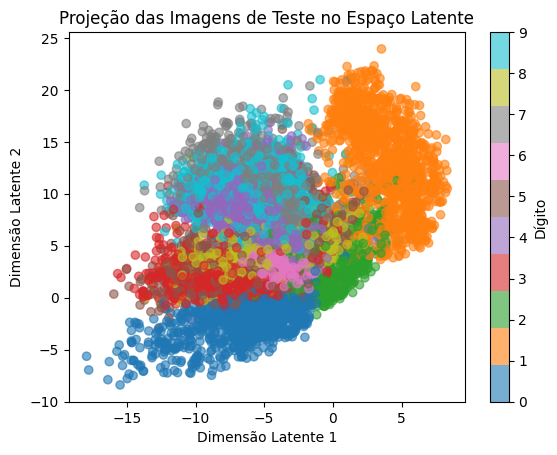

In [15]:
# Teste e visualização
with torch.no_grad():
    latent_space_samples = []
    test_labels = []
    
    for batch_features, labels in test_loader:
        encoded_imgs = autoencoder.encoder(batch_features).cpu().numpy() # Move to CPU before converting to numpy
        latent_space_samples.append(encoded_imgs)
        test_labels.append(labels.cpu().numpy())
    
    latent_space_samples = np.concatenate(latent_space_samples, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    plt.scatter(latent_space_samples[:, 0], latent_space_samples[:, 1], c=test_labels, cmap='tab10', alpha=0.6)
    plt.colorbar(label='Dígito')
    plt.xlabel('Dimensão Latente 1')
    plt.ylabel('Dimensão Latente 2')
    plt.title('Projeção das Imagens de Teste no Espaço Latente')
    plt.show()

Observando o plot, é possível ver que o modelo agrupou bem os dígitos, especialmente 0 e 2, que parecem estar bem isolados dos demais. Porém, a sobreposição dos pontos também é uma boa informação, que nos diz que o autoencoder aprendeu representações latentes que permitem uma transição suave entre dígitos, uma característica desejável na geração de imagens.